::: {#fig-ds4sci style="text-align:center;"}

[![](../assets/ds4sci.svg)]{.stretch}


This work was done as part of the DeepSpeed4Science project, in collaboration with Microsoft.
:::

The new [Megatron-DeepSpeed](https://github.com/microsoft/Megatron-DeepSpeed)
release contains a variety of improvements / optimizations to enable
pre-training Transformer based architectures with significantly longer
sequences than was previously possible.

<!-- > **Note**<br> -->
<!-- > Additional details can be found in the -->
<!-- > [📁 `DeepSpeed4Science`](https://github.com/microsoft/Megatron-DeepSpeed/examples_deepspeed/deepspeed4science/megatron_long_seq_support/README.md) -->
<!-- > folder. -->

::: {.callout-tip icon=false title="[{{< fa solid newspaper >}}]{.green-text} Additional Details" collapse="false" style="width:100%;"}

Additional details can be found in the
[📁 `DeepSpeed4Science`](https://github.com/microsoft/Megatron-DeepSpeed/tree/main/examples_deepspeed/deepspeed4science/megatron_long_seq_support)
folder.

:::


## [DeepSpeed4Science](https://ai4science.azurewebsites.net/2023/09/18/model-showcase-genslms/) (09/2023)

### New Features

- Enabled Megatron-LM's sequence parallel.

- Enabled rotary positional embedding.

- Enabled FlashAttention v1 and v2.

- Enabled new fused kernels from NVIDIA.

### New optimizations

- Enabled attention map memory optimization, where we first generated
attention mask on CPU memory and then moved it into GPU memory to avoid
out-of-memory errors when training with very large sequence lengths.

- Position embedding partitioning, where we split weights of position
encoding across all GPUs when enabling sequence parallel to further reduce
the memory footprint.

### Initial Results

| Sequence Length | Old Megatron-DeepSpeed (TFLOPS) | New Megatron-DeepSpeed (TFLOPS) |
|:---------------:|:--------------------------------:|:--------------------------------:|
| 2k              | [25]{style="text-weight:600;"}                       | [68]{style="text-weight:600;"}                  |
| 4k              | [28]{style="text-weight:600;"}          | [80]{style="text-weight:600;"}                   |
| 8k              | [OOM]{.red-text}                              | [86]{style="text-weight:600;"}                    |
| 16k             | [OOM]{.red-text}                              | [92]{style="text-weight:600;"}                    |
| 32k             | [OOM]{.red-text}                              | [100]{style="text-weight:600;"}                 |
| 64k             | [OOM]{.red-text}                              | [106]{style="text-weight:600;"}                  |
| 128k            | [OOM]{.red-text}                              | [119]{style="text-weight:600;"}                  |
| 256k            | [OOM]{.red-text}                              | [94]{style="text-weight:600;"}                    |

: Long sequence length support[^settings] from [`microsoft/Megatron-DeepSpeed`](https://github.com/microsoft/Megatron-DeepSpeed) {#tbl-results .striped .hover}

[^settings]: The described experiments were performed on 4 NVIDIA DGX A100-40GB nodes, all
using `TPSIZE=32`[^tpsize], connected through 8 HDR InfiniBand (200Gb/s per
HDR). 

[^tpsize]:|
  TP stands for `tensor-model-parallel-size` parallelism.


In [1]:
#| code-fold: true
#| code-summary: "Imports + Setup"
#| echo: false
%matplotlib inline
import matplotlib_inline
import os
import numpy as np
import datetime
from typing import Tuple
import matplotlib.pyplot as plt
from pathlib import Path
# NOTE:
# - [Toolbox](https://github.com/saforem2/toolbox)
from toolbox import set_plot_style
import seaborn as sns
from opinionated import STYLES
import seaborn as sns

sns.set_context('talk')
set_plot_style()
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

plt.style.use('default')
set_plot_style()
plt.style.use(STYLES['opinionated_min'])
plt.rcParams['ytick.labelsize'] = 14.0
plt.rcParams['xtick.labelsize'] = 14.0
plt.rcParams['grid.alpha'] = 0.4

grid_color = plt.rcParams['grid.color']

def save_figure(
        fname: str,
        outdir: os.PathLike,
):
    pngdir = Path(outdir).joinpath('pngs')
    svgdir = Path(outdir).joinpath('svgs')
    pngdir.mkdir(exist_ok=True, parents=True)
    svgdir.mkdir(exist_ok=True, parents=True)
    pngfile = pngdir.joinpath(f'{fname}.png')
    svgfile = svgdir.joinpath(f'{fname}.svg')
    _ = plt.savefig(pngfile, dpi=400, bbox_inches='tight')
    _ = plt.savefig(svgfile, dpi=400, bbox_inches='tight')

Failed to download font: Source Sans Pro, skipping!


Failed to download font: Titillium WebRoboto Condensed, skipping!


In [2]:
#| code-fold: true
#| code-summary: Data
gpus = ('32', '64', '128')

colors = {
    'Old Megatron-DS': '#FF5252',
    'Megatron-LM': '#76b900',
    'New Megatron-DS':  '#1A8FFF',
}

data = {
    '25B': {
        'Old Megatron-DS': np.array([28, 32, 32]),
        'Megatron-LM': np.array([14, 46, 52]),
        'New Megatron-DS': np.array([128, 384, 448]),
    },
    '33B': {
        'Old Megatron-DS': np.array([36, 42, 42]),
        'Megatron-LM': np.array([26, 48, 52]),
        'New Megatron-DS': np.array([192, 448, 512]),
    }
}

::: {#fig-seq-len style="background-color:none;"}


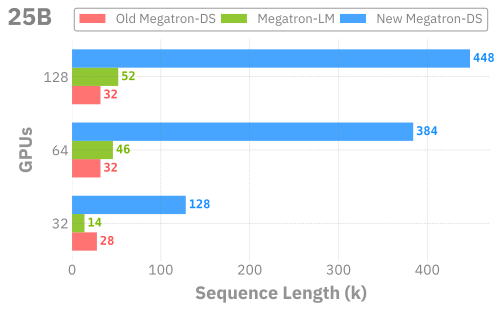

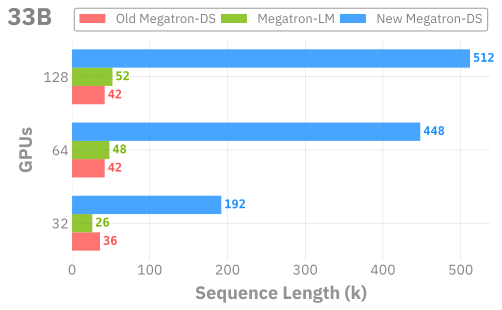

In [3]:
#| code-fold: true
#| code-summary: Make the plots
#| layout-nrow: 1
#| layout-ncol: 2
#| fig-cap:
#|   - "GPT-`25B` Model"
#|   - "GPT-`33B` Model"
x = np.arange(len(gpus))
width = 0.25
multiplier = 0

outdir = Path(os.getcwd()).joinpath('assets')
outdir.mkdir(exist_ok=True, parents=True)

improvement = {}
for idx, (model_size, d) in enumerate(data.items()):
    multiplier = 0
    figure, axes = plt.subplots(figsize=(7.5, 4))
    fig = plt.gcf()
    ax = plt.gca()
    for label, value in d.items():
        offset = width * multiplier
        rects = ax.barh(
          x + offset,
          value,
          width,
          label=label,
          color=colors[label],
          alpha=0.8
        )
        ax.bar_label(
          rects,
          padding=3,
          color=colors[label],
          family='monospace',
          weight='bold'
        )
        multiplier += 1
    ax.set_ylabel(
        'GPUs',
        fontsize=18,
        family='sans-serif',
        loc='center',
    )
    ax.set_yticks(x + width, gpus)
    plt.figtext(
        0.005, 0.93, f"{model_size}", fontsize=24, fontweight='bold', ha='left'
    )
    ax.set_xlabel(
        'Sequence Length (k)', fontsize=18, loc='center'
    )
    ax.legend(
        bbox_to_anchor=(0.005, 1.04, 0.99, .098),
        alignment='center',
        edgecolor="#83838320",
        frameon=True,
        ncols=3,
        fontsize=13,
        mode="expand",
        borderaxespad=0.01
    )
    save_figure(fname=f'{model_size}', outdir=outdir)
    _ = plt.show()

Pre-training with long sequence support across different model sizes and numbers
of GPUs.
In each case, the `new` (current) implementation **significantly**
outperforms both NVIDIA/Megatron-LM as well as our previous implementation.
:::


## Installation

### Using [`install.sh`](https://github.com/ramanathanlab/genslm/blob/foremans/ds4sci/examples/long-sequences/install.sh)

::: {.callout-tip title="Installation" collapse="false" style="width:100%;"}

**Important**<br>
To install, simply:
```bash
git clone https://github.com/ramanthanlab/GenSLM/
cd GenSLM/examples/long-sequences/
./install.sh
``````
Explicitly,
[`./install.sh`](https://github.com/ramanathanlab/genslm/blob/foremans/ds4sci/examples/long-sequences/install.sh)
will:

1. **Automatically** create a virtual environment _on top of_ the latest `conda` module
2. Install (+ update[^update]) / build all the required [dependencies](#dependencies) into this virtual environment

:::

[^update]:|
  2. `deepspeed-0.10.3`
  1. `pytorch==2.0.0+cu118`


### Step-by-Step

For completeness, we describe below the steps for installing and building each
of the dependencies.

1. Clone GitHub repo:
   ```bash
   git clone https://github.com/ramanthanlab/GenSLM
   ``````

2. Load `conda` module:
    - ThetaGPU:
      ```bash
      # ThetaGPU:
      if [[ "$(hostname)==theta*" ]]; then
          export MACHINE="ThetaGPU"
          export CONDA_DATE="2023-01-10"
          module load conda/2023-01-11
          conda activate base
      fi
      ```
    - Polaris:
      ```bash
      # Polaris:
      if [[ "$(hostname)==x3*" ]]; then
          export MACHINE="Polaris"
          export CONDA_DATE="2023-01-10"
          module load conda/2023-01-10-unstable
          conda activate base
      fi
      ```

3. Setup Virtual Environment[^venv]:
   ```bash
   cd ./genslm/examples/long-sequences
   # create a new virtual environment
   mkdir -p "venvs/${MACHINE}/${CONDA_DATE}"
   python3 -m venv "venvs/${MACHINE}/${CONDA_DATE}" --system-site-packages
   source "venvs/${MACHINE}/${CONDA_DATE}/bin/activate"
   ``````

4. Create a new folder (`genslm/examples/long-sequences/deps/${MACHINE}`) where
   we'll installing dependencies locally:
   ```bash
   mkdir -p "deps/${MACHINE}"
   cd "deps/${MACHINE}"
   ```

[^venv]: Where `"${MACHINE}"` $\in$ `{"ThetaGPU", "Polaris"}` and
  `"${CONDA_DATE}"` $\in$ `{"2023-01-10", "2023-01-11"}`

#### Dependencies

We provide below the details needed to install each of the required dependencies.

<details>
<summary>[{{< fa brands github >}} `saforem2/ezpz`](https://github.com/saforem2/ezpz)</summary>

1. [{{< fa brands github >}} `saforem2/ezpz`](https://github.com/saforem2/ezpz)
   ```bash
   pip install -e "git+https://github.com/saforem2/ezpz.git#egg=ezpz"
   ```

</details>

<details>
<summary>[{{< fa brands github >}} `Microsoft/DeepSpeed`](https://github.com/microsoft/DeepSpeed)
</summary>

2. [{{< fa brands github >}} `Microsoft/DeepSpeed`](https://github.com/microsoft/DeepSpeed)
   ```bash
   git clone https://github.com/microsoft/DeepSpeed.git
   cd DeepSpeed
   python3 -m pip install -e .
   ``````
</details>

<details>
<summary>[{{< fa brands github >}} `Microsoft/Megatron-DeepSpeed`](https://github.com/microsoft/Megatron-DeepSpeed)
</summary>

3. [{{< fa brands github >}} `Microsoft/Megatron-DeepSpeed`](https://github.com/microsoft/Megatron-DeepSpeed):
   ```bash
   git clone https://github.com/microsoft/Megatron-DeepSpeed.git
   ```
</details>


<details>
<summary> [{{< fa brands github >}} `NVIDIA/apex`](https://github.com/NVIDIA/apex)
</summary>

4. [{{< fa brands github >}} `NVIDIA/apex`](https://github.com/NVIDIA/apex)
   ```bash
   git clone https://github.com/NVIDIA/apex
   cd ../apex/
   pip install -v --disable-pip-version-check --no-cache-dir --no-build-isolation --global-option="--cpp_ext" --global-option="--cuda_ext" -e ./
   ``````
</details>

<details>
<summary>[{{< fa brands github >}} `pybind/PyBind11`](https://github.com/pybind/pybind11)</summary>

5. [{{< fa brands github >}} `pybind/PyBind11`](https://github.com/pybind/pybind11)
   ```bash
   pip install pybind11
   ``````

</details>

<details>
<summary>[{{< fa brands github >}} `Dao-AILab/flash-attention`](https://github.com/Dao-AILab/flash-attention)</summary>

6. [{{< fa brands github >}} `Dao-AILab/flash-attention`](https://github.com/Dao-AILab/flash-attention):

   ::: {.callout-caution title="Flash Attention" collapse="true" style="font-size:0.8em; width:100%;"}
    - The new release supports three different implementations of
      FlashAttention: (`v1.0.4`, `v2.x`, `triton`)
    - FlashAttention `v2.x` may have numerical instability issues.
      For the best performance, we recommend using FlashAttention + Triton
   :::

   - `v1.0.4`:
     ```bash
     python3 -m pip install flash-attn==1.0.4
     ```
   - `v2.x`:
     ```bash
     git clone https://github.com/Dao-AILab/flash-attention
     cd flash-attention
     python3 setup.py install
     ```
   - `openai/triton`:
     ```bash
     git clone -b legacy-backend https://github.com/openai/triton
     cd triton/python
     python3 -m pip install cmake
     python3 -m pip install .
     ```

</details>

## Running

The [`ALCF/`](./ALCF/) directory contains shell scripts for setting up the
environment and specifying the options to be used when launching.

Various options can be specified dynamically at runtime by setting them in your
environment, e.g.:

```bash
MODEL_SIZE_KEY="GPT25B" SEQ_LEN=128000 USE_FLASH_ATTN=1 MICRO_BATCH=1 GAS=1 SP_TYPE="megatron" ZERO_STAGE=1 ./ALCF/train-gpt3.sh
``````

Explicitly:

- [`ALCF/train-gpt3.sh`](./ALCF/train-gpt3.sh): **Main entry point for training**
  - This script will **automatically** source the rest of the required [`ALCF/*.sh`](./ALCF/) scripts below
- [`ALCF/models.sh`](./ALCF/models.sh): Contains some example model architectures for GPT3-style models
- [`ALCF/args.sh`](./ALCF/args.sh): Logic for parsing / setting up runtime options for Megatron and DeepSpeed
- [`ALCF/setup.sh`](./ALCF/args.sh): Locate and activate virtual environment to be used, ensure MPI variables are set properly
- [`ALCF/launch.sh`](./ALCF/launch.sh): Identify available resources and build the command to be executed
  - i.e. figure out how many: `{nodes, GPUs per node, GPUs total}`, to pass to `mpi{run,exec}`
  - then, use this to build `mpiexec <mpiexec-args> python3 pretrain_gpt.py`


## ZeRO Offloading

[🚀 **W&B Report**: _Looooooooong Sequences_](https://wandb.ai/l2hmc-qcd/Megatron-DS-Benchmarking/reports/Looooooong-Sequences--Vmlldzo1MzI2NjA1)

These newly introduced optimizations, in combination with
[ZeRO-Offload](https://www.deepspeed.ai/tutorials/zero-offload/) allows us to go even further.

By employing ZeRO-Offloading, we are able to free up additional memory which
can be used for _even longer_ sequences.

Though work is still ongoing, this is a promising direction that will allow us
to consider significantly larger genomes than previously possible.

We use [Weights \& Biases](https://wandb.ai) to track these experiments, and
have aggregated our initial results in the [W\&B
Report](https://wandb.ai/l2hmc-qcd/Megatron-DS-Benchmarking/reports/Looooooong-Sequences--Vmlldzo1MzI2NjA1)
below.

We can evaluate the performance of our model by looking at two different
metrics for throughput: `samples_per_sec` and `TFLOPS`.

Explicitly, we see that we are able to scale up to significantly longer
sequences (`420k / 128k ~ 3.3x`) with only a minimal impact on throughput
performance (`81 / 105 ~ 77\%`)[^tflops-scaling].


|  Name  | Sequence Length (k) | (`seq_len / min_seq_len`) |  TFLOPS  | TFLOPS (% of peak) |
|:------:|:-------------------:|:-----------------------:|:--------:|:------------------:|
| GPT25B |         420         |         [**3.28125**]{.blue-text}         | 81.77225 |       [**77.867**]{.blue-text}       |
| GPT25B |         400         |          3.125          |  90.62   |       86.297       |
| GPT25B |         360         |         2.8125          | 81.6325  |      77.7348       |
| GPT25B |         360         |         2.8125          | 82.6824  |      78.7346       |
| GPT25B |         192         |           1.5           | 115.8228 |      110.2927      |
| GPT25B |         128         |            1            | 106.672  |      101.5788      |
| GPT25B |         128         |            1            | 105.014  |       100.00       |

: Impact on TFLOPS as a function of increasing sequence length. Table from: [`throughput/TFLOPS`](https://api.wandb.ai/links/l2hmc-qcd/awklywn7) {#tbl-seqlen .striped .hover}

<!-- [^config]: Using: `{model_size: 25B, WORLD_SIZE: 32, micro_batch: 1}` -->
[^tflops-scaling]: [`throughput/TFLOPS`](https://api.wandb.ai/links/l2hmc-qcd/awklywn7)

<!-- <iframe src="https://wandb.ai/l2hmc-qcd/Megatron-DS-Benchmarking?workspace=user-saforem2" style="border:none;height:1024px;width:100%"> -->

::: {#fig-wandb}

:::  {style="padding:0.5rem; border: 1px solid var(--dim-text); border-radius: 0.2rem;"}

<iframe src="https://wandb.ai/l2hmc-qcd/Megatron-DS-Benchmarking/reports/Looooooong-Sequences--Vmlldzo1MzI2NjA1" style="border:none;height:1024px;width:100%">
</iframe>

:::

Weights \& Biases Report

:::
